# Outline
1. policy evaluation for random policy
2. policy iteration
3. in-place policy iteration
4. value iteration
5. in-place value iteration
6. Comparison about the convergence rate of above method 

Thanks to my seniors for providing me with base code.

In [1]:
import numpy as np
import time
WORLD_SIZE = 5
N_ACTIONS = 4  # [North, South, West, East]
gamma = 0.9
v_policy=[]
v_value=[]
v_inplace_value=[]
v_inplace_policy=[]
class Env(object):
    def __init__(self):

        self.A_pos = [0, 1]
        self.A_n_pos = [4, 1]
        self.B_pos = [0, 3]
        self.B_n_pos = [2, 3]

        self.Snext_sa = np.empty((WORLD_SIZE, WORLD_SIZE, 4), dtype=np.object)
        #matrix Snext_sa stores the next state under the s and a conditions.
        self.R_sa = np.zeros((WORLD_SIZE, WORLD_SIZE, 4))
        for i in range(WORLD_SIZE):
            for j in range(WORLD_SIZE):
                for a in range(N_ACTIONS):
                    s = [i, j]
                    if a == 0:   #North
                        if i == 0:
                            s_n = s
                            r = -1
                        else: 
                            s_n = [i-1, j]
                            r = 0
                    elif a == 1:  #South
                        if i == WORLD_SIZE - 1:
                            s_n = s
                            r = -1
                        else:
                            s_n = [i+1, j]
                            r = 0
                    elif a == 2: # West
                        if j == 0:
                            s_n = s
                            r = -1
                        else:
                            s_n = [i, j-1]
                            r = 0
                    else:  # East
                        if j == WORLD_SIZE - 1:
                            s_n = s
                            r = -1
                        else:
                            s_n = [i, j+1]
                            r = 0
                            
                    if s == self.A_pos:
                        s_n = self.A_n_pos
                        r = 10
                    elif s == self.B_pos:
                        s_n = self.B_n_pos
                        r = 5
                    
                    self.Snext_sa[i,j,a] = s_n
                    self.R_sa[i,j,a] = r

## 1. policy evaluation for random policy

In [2]:
random_policy = np.full((WORLD_SIZE, WORLD_SIZE, N_ACTIONS),
                        1. / N_ACTIONS, dtype=np.float32)

In [3]:
def policy_evaluate(policy, env, max_step=1000, tol=1e-6):
    V = np.zeros((WORLD_SIZE, WORLD_SIZE), dtype=np.float32)  
    update_step = 0
    for _ in range(max_step):
        new_V = V.copy()
        for i in range(WORLD_SIZE):
            for j in range(WORLD_SIZE):  # s(i,j):current state
                qs = np.zeros((N_ACTIONS,), dtype=np.float32)   # q(s,a) for s(i,j)
                for a in range(N_ACTIONS):
                    n_s = env.Snext_sa[i, j, a]#n_s:next state
                    r = env.R_sa[i, j, a]
                    n_V = V[n_s[0], n_s[1]]#V(next state)
                    qs[a] = r + gamma * n_V#q(current state,a))=R_sa+gamma*sum(P_ssa*V(next state))=R_sa+gamma*V(next state)
                new_V[i, j] = np.sum(qs * policy[i, j])#V_pi(s(i,j))=sum_all_a(pi(a|s(i,j))*q(s(i,j),a))
        v_policy.append(np.mean(V))
        if np.sum(np.abs(V - new_V)) < tol:
            break
        V = new_V
    return V   

In [5]:
env = Env()
random_V = policy_evaluate(random_policy, env)
print(random_V)

[[ 3.308997    8.789292    4.42762     5.322368    1.4921793 ]
 [ 1.5215887   2.9923184   2.2501407   1.9075724   0.5474032 ]
 [ 0.05082303  0.73817116  0.6731138   0.3581868  -0.4031406 ]
 [-0.97359174 -0.43549493 -0.3548817  -0.58560455 -1.1830745 ]
 [-1.8577001  -1.3452307  -1.2292668  -1.4229176  -1.9751785 ]]


In [6]:
%%html
<img src='Gridworld.jpg' >

## 2.policy iteration

In [7]:
def policy_iteration(max_iter=100):
    env=Env()
    policy= np.full((WORLD_SIZE, WORLD_SIZE, N_ACTIONS),
                        1. / N_ACTIONS, dtype=np.float32)
    for i in range(max_iter):
        V = policy_evaluate(policy, env)
        last_policy=policy
        policy=policy_improvement(V,env)
        print("the iter num:",i,policy)
        if (last_policy==policy).all():
            break
    return policy,V
    

In [9]:
def policy_improvement(V,env):
    policy= np.zeros((WORLD_SIZE, WORLD_SIZE, N_ACTIONS), dtype=np.float32)
    for i in range(WORLD_SIZE):
        for j in range(WORLD_SIZE):  # s(i,j):current state
            qs = np.zeros((N_ACTIONS,), dtype=np.float32)   # q(s,a) for s(i,j)
            for a in range(N_ACTIONS):
                n_s = env.Snext_sa[i, j, a]#n_s:next state
                r = env.R_sa[i, j, a]
                n_V = V[n_s[0], n_s[1]]#V(next state)
                qs[a] = r + gamma * n_V#q(current state,a))=R_sa+gamma*sum(P_ssa*V(next state))=R_sa+gamma*V(next state)
            policy[i,j]=action_choose(list(qs))
    return policy

In [10]:
def action_choose(qs):
    p=np.zeros((N_ACTIONS,), dtype=np.float32)
    maxq=max(qs)
    repeat=qs.count(maxq)
    for i,value in enumerate(qs):
        if value==maxq:
            p[i]=1/repeat
    return p

In [14]:
%%html
<img src='Gridworld_optimal.jpg' >

In [11]:
policy_best,V_best=policy_iteration()

the iter num: 0 [[[0.   0.   0.   1.  ]
  [0.25 0.25 0.25 0.25]
  [0.   0.   1.   0.  ]
  [0.25 0.25 0.25 0.25]
  [0.   0.   1.   0.  ]]

 [[1.   0.   0.   0.  ]
  [1.   0.   0.   0.  ]
  [1.   0.   0.   0.  ]
  [1.   0.   0.   0.  ]
  [0.   0.   1.   0.  ]]

 [[1.   0.   0.   0.  ]
  [1.   0.   0.   0.  ]
  [1.   0.   0.   0.  ]
  [1.   0.   0.   0.  ]
  [1.   0.   0.   0.  ]]

 [[1.   0.   0.   0.  ]
  [1.   0.   0.   0.  ]
  [1.   0.   0.   0.  ]
  [1.   0.   0.   0.  ]
  [1.   0.   0.   0.  ]]

 [[1.   0.   0.   0.  ]
  [1.   0.   0.   0.  ]
  [1.   0.   0.   0.  ]
  [1.   0.   0.   0.  ]
  [1.   0.   0.   0.  ]]]
the iter num: 1 [[[0.   0.   0.   1.  ]
  [0.25 0.25 0.25 0.25]
  [0.   0.   1.   0.  ]
  [0.25 0.25 0.25 0.25]
  [0.   0.   1.   0.  ]]

 [[0.5  0.   0.   0.5 ]
  [1.   0.   0.   0.  ]
  [0.5  0.   0.5  0.  ]
  [0.   0.   1.   0.  ]
  [0.5  0.   0.5  0.  ]]

 [[0.5  0.   0.   0.5 ]
  [1.   0.   0.   0.  ]
  [0.5  0.   0.5  0.  ]
  [0.   0.   1.   0.  ]
  [0.5  0.   0.5  

In [12]:
V_best

array([[21.977484, 24.419426, 21.977484, 19.419426, 17.477484],
       [19.779736, 21.977484, 19.779736, 17.801762, 16.021585],
       [17.801762, 19.779736, 17.801762, 16.021585, 14.419427],
       [16.021585, 17.801762, 16.021585, 14.419427, 12.977484],
       [14.419427, 16.021585, 14.419427, 12.977484, 11.679734]],
      dtype=float32)

In [13]:
policy_best

array([[[0.  , 0.  , 0.  , 1.  ],
        [0.25, 0.25, 0.25, 0.25],
        [0.  , 0.  , 1.  , 0.  ],
        [0.25, 0.25, 0.25, 0.25],
        [0.  , 0.  , 1.  , 0.  ]],

       [[0.5 , 0.  , 0.  , 0.5 ],
        [1.  , 0.  , 0.  , 0.  ],
        [0.5 , 0.  , 0.5 , 0.  ],
        [0.  , 0.  , 1.  , 0.  ],
        [0.  , 0.  , 1.  , 0.  ]],

       [[0.5 , 0.  , 0.  , 0.5 ],
        [1.  , 0.  , 0.  , 0.  ],
        [0.5 , 0.  , 0.5 , 0.  ],
        [0.5 , 0.  , 0.5 , 0.  ],
        [0.5 , 0.  , 0.5 , 0.  ]],

       [[0.5 , 0.  , 0.  , 0.5 ],
        [1.  , 0.  , 0.  , 0.  ],
        [0.5 , 0.  , 0.5 , 0.  ],
        [0.5 , 0.  , 0.5 , 0.  ],
        [0.5 , 0.  , 0.5 , 0.  ]],

       [[0.5 , 0.  , 0.  , 0.5 ],
        [1.  , 0.  , 0.  , 0.  ],
        [0.5 , 0.  , 0.5 , 0.  ],
        [0.5 , 0.  , 0.5 , 0.  ],
        [0.5 , 0.  , 0.5 , 0.  ]]], dtype=float32)

## 3. inplace policy iteration

In [21]:
def inplace_policy_evaluate(policy, env, max_step=1000, tol=1e-6):
    V = np.zeros((WORLD_SIZE, WORLD_SIZE), dtype=np.float32)  
    update_step = 0
    for _ in range(max_step):
        new_V = V.copy()
        for i in range(WORLD_SIZE):
            for j in range(WORLD_SIZE):  # s(i,j):current state
                qs = np.zeros((N_ACTIONS,), dtype=np.float32)   # q(s,a) for s(i,j)
                for a in range(N_ACTIONS):
                    n_s = env.Snext_sa[i, j, a]#n_s:next state
                    r = env.R_sa[i, j, a]
                    n_V = V[n_s[0], n_s[1]]#V(next state)
                    qs[a] = r + gamma * n_V#q(current state,a))=R_sa+gamma*sum(P_ssa*V(next state))=R_sa+gamma*V(next state)
                V[i, j] = np.sum(qs * policy[i, j])#V_pi(s(i,j))=sum_all_a(pi(a|s(i,j))*q(s(i,j),a))
        v_inplace_policy.append(np.mean(V))
        if np.sum(np.abs(V - new_V)) < tol:
            break       
    return V   

In [8]:
def inplace_policy_iteration(max_iter=100):
    env=Env()
    policy= np.full((WORLD_SIZE, WORLD_SIZE, N_ACTIONS),
                        1. / N_ACTIONS, dtype=np.float32)
    for i in range(max_iter):
        V = inplace_policy_evaluate(policy, env)
        last_policy=policy
        policy=policy_improvement(V,env)
        print("!")
        if (last_policy==policy).all():
            break
    return policy,V
    

In [19]:
inplace_policy_iteration()

!
!
!
!
!


(array([[[0.  , 0.  , 0.  , 1.  ],
         [0.25, 0.25, 0.25, 0.25],
         [0.  , 0.  , 1.  , 0.  ],
         [0.25, 0.25, 0.25, 0.25],
         [0.  , 0.  , 1.  , 0.  ]],
 
        [[0.5 , 0.  , 0.  , 0.5 ],
         [1.  , 0.  , 0.  , 0.  ],
         [0.5 , 0.  , 0.5 , 0.  ],
         [0.  , 0.  , 1.  , 0.  ],
         [0.  , 0.  , 1.  , 0.  ]],
 
        [[0.5 , 0.  , 0.  , 0.5 ],
         [1.  , 0.  , 0.  , 0.  ],
         [0.5 , 0.  , 0.5 , 0.  ],
         [0.5 , 0.  , 0.5 , 0.  ],
         [0.5 , 0.  , 0.5 , 0.  ]],
 
        [[0.5 , 0.  , 0.  , 0.5 ],
         [1.  , 0.  , 0.  , 0.  ],
         [0.5 , 0.  , 0.5 , 0.  ],
         [0.5 , 0.  , 0.5 , 0.  ],
         [0.5 , 0.  , 0.5 , 0.  ]],
 
        [[0.5 , 0.  , 0.  , 0.5 ],
         [1.  , 0.  , 0.  , 0.  ],
         [0.5 , 0.  , 0.5 , 0.  ],
         [0.5 , 0.  , 0.5 , 0.  ],
         [0.5 , 0.  , 0.5 , 0.  ]]], dtype=float32),
 array([[21.977484, 24.419426, 21.977484, 19.419426, 17.477484],
        [19.779736, 21.977484,

## 4. value iteration

In [15]:
def value_iteration( max_step=1000, tol=1e-6):
    env=Env()
    V = np.zeros((WORLD_SIZE, WORLD_SIZE), dtype=np.float32)  
    update_step = 0
    for _ in range(max_step):
        new_V = V.copy()
        for i in range(WORLD_SIZE):
            for j in range(WORLD_SIZE):  # s(i,j):current state
                qs = np.zeros((N_ACTIONS,), dtype=np.float32)   # q(s,a) for s(i,j)
                for a in range(N_ACTIONS):
                    n_s = env.Snext_sa[i, j, a]#n_s:next state
                    r = env.R_sa[i, j, a]
                    n_V = V[n_s[0], n_s[1]]#V(next state)
                    qs[a] = r + gamma * n_V#q(current state,a))=R_sa+gamma*sum(P_ssa*V(next state))=R_sa+gamma*V(next state)
                new_V[i, j] = np.max(qs)#V_*(s(i,j))=max_a(pi(a|s(i,j))*q(s(i,j),a))
        v_value.append(np.mean(V))
        if np.sum(np.abs(V - new_V)) < tol:
            break
        V = new_V
    policy= np.zeros((WORLD_SIZE, WORLD_SIZE, N_ACTIONS), dtype=np.float32)
    for i in range(WORLD_SIZE):
        for j in range(WORLD_SIZE):  # s(i,j):current state
            qs = np.zeros((N_ACTIONS,), dtype=np.float32)   # q(s,a) for s(i,j)
            for a in range(N_ACTIONS):
                n_s = env.Snext_sa[i, j, a]#n_s:next state
                r = env.R_sa[i, j, a]
                n_V = V[n_s[0], n_s[1]]#V(next state)
                qs[a] = r + gamma * n_V#q(current state,a))=R_sa+gamma*sum(P_ssa*V(next state))=R_sa+gamma*V(next state)
            policy[i,j]=action_choose(list(qs))    
    return policy,V

In [16]:
value_iteration()

(array([[[0.  , 0.  , 0.  , 1.  ],
         [0.25, 0.25, 0.25, 0.25],
         [0.  , 0.  , 1.  , 0.  ],
         [0.25, 0.25, 0.25, 0.25],
         [0.  , 0.  , 1.  , 0.  ]],
 
        [[0.5 , 0.  , 0.  , 0.5 ],
         [1.  , 0.  , 0.  , 0.  ],
         [0.5 , 0.  , 0.5 , 0.  ],
         [0.  , 0.  , 1.  , 0.  ],
         [0.  , 0.  , 1.  , 0.  ]],
 
        [[0.5 , 0.  , 0.  , 0.5 ],
         [1.  , 0.  , 0.  , 0.  ],
         [0.5 , 0.  , 0.5 , 0.  ],
         [0.5 , 0.  , 0.5 , 0.  ],
         [0.5 , 0.  , 0.5 , 0.  ]],
 
        [[0.5 , 0.  , 0.  , 0.5 ],
         [1.  , 0.  , 0.  , 0.  ],
         [0.5 , 0.  , 0.5 , 0.  ],
         [0.5 , 0.  , 0.5 , 0.  ],
         [0.5 , 0.  , 0.5 , 0.  ]],
 
        [[0.5 , 0.  , 0.  , 0.5 ],
         [1.  , 0.  , 0.  , 0.  ],
         [0.5 , 0.  , 0.5 , 0.  ],
         [0.5 , 0.  , 0.5 , 0.  ],
         [0.5 , 0.  , 0.5 , 0.  ]]], dtype=float32),
 array([[21.977484, 24.419426, 21.977484, 19.419426, 17.477484],
        [19.779736, 21.977484,

## 5. inplace value iteration

In [17]:
def inplace_value_iteration( max_step=1000, tol=1e-6):
    env=Env()
    V = np.zeros((WORLD_SIZE, WORLD_SIZE), dtype=np.float32)  
    update_step = 0
    for _ in range(max_step):
        new_V = V.copy()
        for i in range(WORLD_SIZE):
            for j in range(WORLD_SIZE):  # s(i,j):current state
                qs = np.zeros((N_ACTIONS,), dtype=np.float32)   # q(s,a) for s(i,j)
                for a in range(N_ACTIONS):
                    n_s = env.Snext_sa[i, j, a]#n_s:next state
                    r = env.R_sa[i, j, a]
                    n_V = V[n_s[0], n_s[1]]#V(next state)
                    qs[a] = r + gamma * n_V#q(current state,a))=R_sa+gamma*sum(P_ssa*V(next state))=R_sa+gamma*V(next state)
                V[i, j] = np.max(qs)#V_*(s(i,j))=max_a(pi(a|s(i,j))*q(s(i,j),a))
        v_inplace_value.append(np.mean(V))
        if np.sum(np.abs(V - new_V)) < tol:
            break
    policy= np.zeros((WORLD_SIZE, WORLD_SIZE, N_ACTIONS), dtype=np.float32)
    for i in range(WORLD_SIZE):
        for j in range(WORLD_SIZE):  # s(i,j):current state
            qs = np.zeros((N_ACTIONS,), dtype=np.float32)   # q(s,a) for s(i,j)
            for a in range(N_ACTIONS):
                n_s = env.Snext_sa[i, j, a]#n_s:next state
                r = env.R_sa[i, j, a]
                n_V = V[n_s[0], n_s[1]]#V(next state)
                qs[a] = r + gamma * n_V#q(current state,a))=R_sa+gamma*sum(P_ssa*V(next state))=R_sa+gamma*V(next state)
            policy[i,j]=action_choose(list(qs))    
    return policy,V

In [18]:
inplace_value_iteration()

(array([[[0.  , 0.  , 0.  , 1.  ],
         [0.25, 0.25, 0.25, 0.25],
         [0.  , 0.  , 1.  , 0.  ],
         [0.25, 0.25, 0.25, 0.25],
         [0.  , 0.  , 1.  , 0.  ]],
 
        [[0.5 , 0.  , 0.  , 0.5 ],
         [1.  , 0.  , 0.  , 0.  ],
         [0.5 , 0.  , 0.5 , 0.  ],
         [0.  , 0.  , 1.  , 0.  ],
         [0.  , 0.  , 1.  , 0.  ]],
 
        [[0.5 , 0.  , 0.  , 0.5 ],
         [1.  , 0.  , 0.  , 0.  ],
         [0.5 , 0.  , 0.5 , 0.  ],
         [0.5 , 0.  , 0.5 , 0.  ],
         [0.5 , 0.  , 0.5 , 0.  ]],
 
        [[0.5 , 0.  , 0.  , 0.5 ],
         [1.  , 0.  , 0.  , 0.  ],
         [0.5 , 0.  , 0.5 , 0.  ],
         [0.5 , 0.  , 0.5 , 0.  ],
         [0.5 , 0.  , 0.5 , 0.  ]],
 
        [[0.5 , 0.  , 0.  , 0.5 ],
         [1.  , 0.  , 0.  , 0.  ],
         [0.5 , 0.  , 0.5 , 0.  ],
         [0.5 , 0.  , 0.5 , 0.  ],
         [0.5 , 0.  , 0.5 , 0.  ]]], dtype=float32),
 array([[21.977484, 24.419426, 21.977484, 19.419426, 17.477484],
        [19.779736, 21.977484,

## 6. Comparison

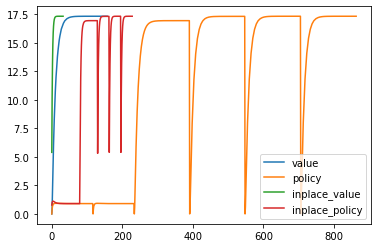

In [20]:
import matplotlib.pyplot as plt
plt.plot(v_value)
plt.plot(v_policy)
plt.plot(v_inplace_value)
plt.plot(v_inplace_policy)
plt.legend(['value iter',
'policy iter',
'inplace_value',
'inplace_policy'])